In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from sklearn.metrics import roc_curve

In [17]:
train_csv_files = [
    ('/vol/biomedic3/bglocker/ugproj/vg521/model/mammo-net/csv/train/cf-and-real-embed-train.csv', 'cf_and_real'),
    ('/vol/biomedic3/bglocker/ugproj/vg521/model/mammo-net/csv/train/cf-embed-train.csv', 'cf_only'),
    ('/vol/biomedic3/bglocker/ugproj/vg521/model/mammo-net/csv/train/real-embed-train.csv', 'real_only'),
    ('/vol/biomedic3/bglocker/ugproj/vg521/model/mammo-net/csv/train/same-class-cf-train.csv', 'same-class-cf')
]

train_csv_dict = {key: value for (value, key) in train_csv_files}

def extract_hparams_from_foldername(filename):
    filename = filename.strip()
    match = re.search(r'([^/]+)_bs(\d+)_lr([\d.]+)_epochs(\d+)', filename)
    if not match:
        print('checkpoint folder name does not match expected pattern')
    if match:
        name_model, batch_size, learning_rate, epochs = match.groups()
        
        parts = name_model.rsplit('_', 1)
        name, model = parts

        batch_size = int(batch_size)
        learning_rate = float(learning_rate)
        epochs = int(epochs)
        return {
            'name': name,
            'train_csv': train_csv_dict[name],
            'model': model,
            'batch_size': int(batch_size),
            'learning_rate': float(learning_rate),
            'epochs': int(epochs),
            'seed': 42,
            'num_devices': 1,
            'num_workers': 6,
            'batch_alpha': 1.0
        }

In [24]:
def get_model_predictions(model_path):
    model_path = Path(model_path)
    
    predictions = Path(model_path/'predictions_balanced.csv')
    df = pd.read_csv(predictions)

    y_true = df['target'].values
    y_prob = df['class_1'].values # choosing class 1 as positive class
    
    return y_true, y_prob

In [18]:
def sensitivity_at_fixed_specificity(y_true, y_prob, target_specificity):
    # Check for NaNs in y_prob or y_true
    if np.isnan(y_prob).any() or np.isnan(y_true).any():
        print("Warning: NaNs detected in inputs — returning N/A.")
        return np.nan, np.nan
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    specificity = 1 - fpr
    
    # Find the closest specificity >= target_specificity
    idx = np.where(specificity >= target_specificity)[0][-1]
    
    sensitivity = tpr[idx]
    threshold = thresholds[idx]
    
    return sensitivity, threshold

In [19]:
def specificity_at_fixed_sensitivity(y_true, y_prob, target_sensitivity):

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    print(f"Max sensitivity achieved: {np.max(tpr)}")
    specificity = 1 - fpr
    
    # Find the closest sensitivity >= target_sensitivity
    idx = np.where(tpr >= target_sensitivity)[0][0]
    
    specificity_at_idx = specificity[idx]
    threshold = thresholds[idx]
    
    return specificity_at_idx, threshold

# def sensitivity_at_fixed_specificity(y_true, y_prob, target_specificity):
#      # Filter out NaNs
#     mask = ~np.isnan(y_true) & ~np.isnan(y_prob)
#     y_true = y_true[mask]
#     y_prob = y_prob[mask]

#     # Now compute ROC
#     fpr, tpr, thresholds = roc_curve(y_true, y_prob)
#     specificity = 1 - fpr

#     # Find closest specificity >= target_specificity
#     mask = specificity >= target_specificity
#     if not np.any(mask):
#         return 0.0, np.inf  # If cannot reach target specificity
#     idx = np.argmax(specificity[mask])
#     sensitivity = tpr[mask][idx]
#     threshold = thresholds[mask][idx]
    
#     return sensitivity, threshold

In [20]:
target_specs = [0.9]
target_sens = [0.9]

In [23]:
def get_sensitivity_at_fixed_specificities(model_dir):

    for ts in target_specs:
        print(f"\n=== Processing target specificity: {ts:.2f} ===")
        results = []  # Initialise once per ts
        
        for model_folder in os.listdir(model_dir):
            model_path = os.path.join(model_dir, model_folder)
            
            hparams = extract_hparams_from_foldername(model_folder)
            
            if os.path.isdir(model_path):
                predictions_path = os.path.join(model_path, 'predictions_balanced.csv')
                
                if os.path.exists(predictions_path):
                    print(f'processing: {model_path}')
                    
                    y_true, y_prob = get_model_predictions(model_path)
                    
                    sensitivity, threshold = sensitivity_at_fixed_specificity(y_true, y_prob, ts)
                    
                    print(f"Sensitivity at {ts*100:.0f}% specificity: {sensitivity:.2f}, Threshold: {threshold:.2f}")
                    
                    results.append({
                        'name': hparams['name'],
                        'model': hparams['model'],
                        'batch_size': hparams['batch_size'],
                        'learning_rate': hparams['learning_rate'],
                        'epochs': hparams['epochs'],
                        'target_spec': ts,
                        'sensitivity': sensitivity,
                        'threshold': threshold 
                    })
        
        # After all models for this ts → save results
        df = pd.DataFrame(results)
        df = df.sort_values('sensitivity', ascending=False)
        df.to_csv(f'same-class-cf-balanced-ts{int(ts*100)}-fixed-specificity.csv', index=False)

In [23]:
def get_specificity_at_fixed_sensitivities(model_dir):
    
    for model_folder in os.listdir(model_dir):
        model_path = os.path.join(model_dir, model_folder)
        
        hparams = extract_hparams_from_foldername(model_folder)
        
        if os.path.isdir(model_path):
            predictions_path = os.path.join(model_path, 'predictions.csv')
            
            if os.path.exists(predictions_path):
                print(f'processing: {model_path}')
                
                y_true, y_prob = get_model_predictions(model_path)
                
                for ts in target_sens:
                    results = []
                    
                    specificity, threshold = specificity_at_fixed_sensitivity(y_true, y_prob, ts)
                            
                    print(f"Specificity at {ts*100:.0f}% specificity: {specificity:.2f}, Threshold: {threshold:.2f}")
                    
                    results.append({
                        'name': hparams['name'],
                        'model': hparams['model'],
                        'batch_size': hparams['batch_size'],
                        'learning_rate': hparams['learning_rate'],
                        'epochs': hparams['epochs'],
                        'sensitivity': specificity,
                        'threshold': threshold 
                    })
                    
                    results = sorted(results, key=lambda x: x['sensitivity'], reverse=True)
                    df = pd.DataFrame(results)
                    df.to_csv(f'res-balanced-{ts}-fixed-sensitivity.csv', index=False)  

In [23]:
def count_class_1s(model_dir):
    results = []
    
    for model_folder in os.listdir(model_dir):
        model_path = os.path.join(model_dir, model_folder)
        
        hparams = extract_hparams_from_foldername(model_folder)
        
        if os.path.isdir(model_path):
            predictions_path = os.path.join(model_path, 'predictions.csv')
            
            if os.path.exists(predictions_path):
                print(f'processing: {model_path}')
                
                y_true, y_prob = get_model_predictions(model_path)
                y_pred = (y_prob >= 0.5).astype(int)

                # Count number of class 0 predictions and class 1 predictions
                unique, counts = np.unique(y_pred, return_counts=True)

                # Print results
                for cls, count in zip(unique, counts):
                    print(f"Predicted class {cls}: {count} samples")

In [25]:
model_dir = Path('same_class_models/')

get_sensitivity_at_fixed_specificities(model_dir)
# get_specificity_at_fixed_sensitivities(model_dir)


=== Processing target specificity: 0.90 ===
processing: same_class_models/same-class-cf_resnet18_bs128_lr0.0003_epochs10
Sensitivity at 90% specificity: 0.94, Threshold: 0.42
processing: same_class_models/same-class-cf_resnet50_bs128_lr0.0003_epochs10
Sensitivity at 90% specificity: 0.93, Threshold: 0.53
processing: same_class_models/same-class-cf_resnet34_bs128_lr0.0003_epochs10
Sensitivity at 90% specificity: 0.93, Threshold: 0.26
processing: same_class_models/same-class-cf_resnet18_bs64_lr0.0001_epochs10
Sensitivity at 90% specificity: 0.93, Threshold: 0.40
processing: same_class_models/same-class-cf_resnet34_bs256_lr0.0005_epochs10
Sensitivity at 90% specificity: 0.93, Threshold: 0.21
processing: same_class_models/same-class-cf_resnet50_bs64_lr0.0001_epochs10
Sensitivity at 90% specificity: 0.93, Threshold: 0.36
processing: same_class_models/same-class-cf_resnet34_bs64_lr0.0001_epochs10
Sensitivity at 90% specificity: 0.93, Threshold: 0.56
processing: same_class_models/same-class-

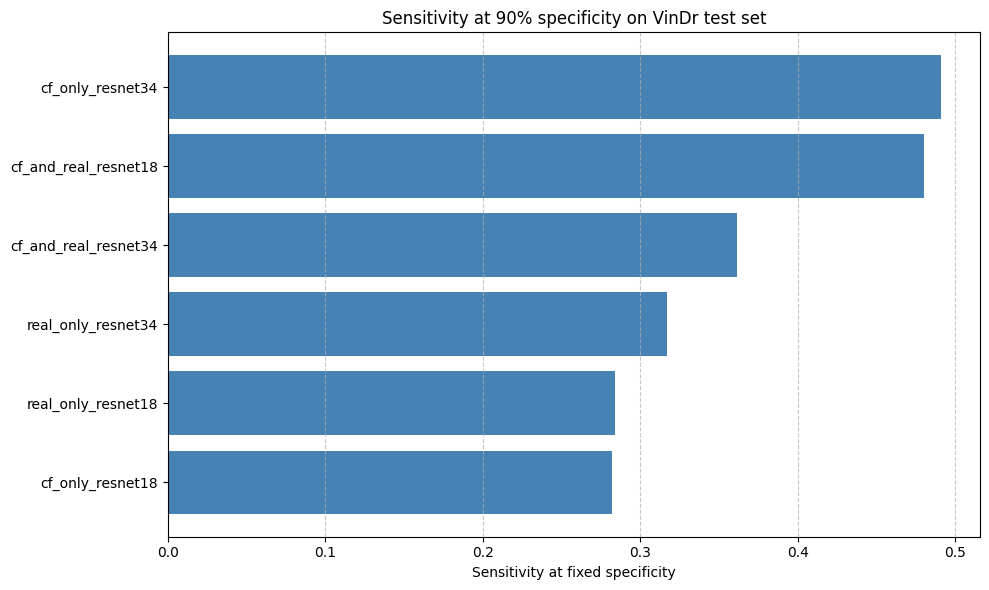

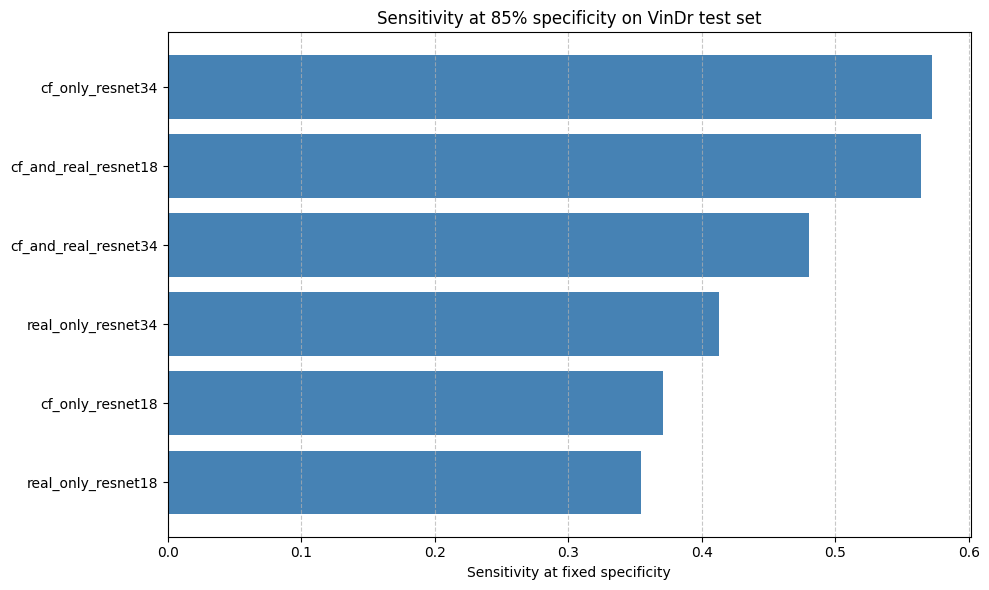

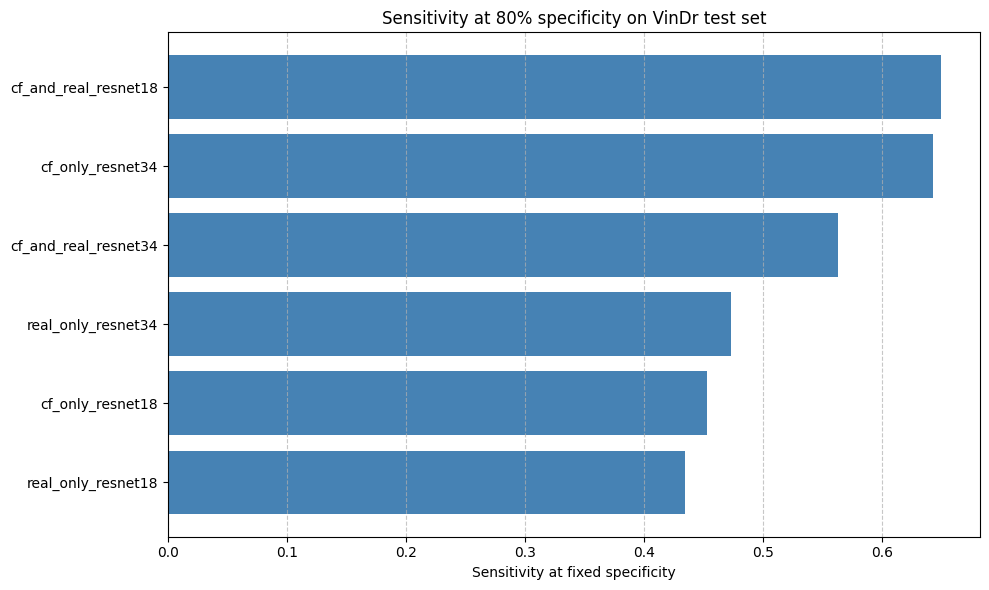

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_sensitivity_comparison(csv_path, title):
    df = pd.read_csv(csv_path)

    # Sort by sensitivity
    df = df.sort_values('sensitivity', ascending=False)

    # Build labels
    model_labels = df['name'] + '_' + df['model']

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(model_labels, df['sensitivity'], color='steelblue')
    plt.xlabel('Sensitivity at fixed specificity')
    plt.title(title)
    plt.gca().invert_yaxis()  # Highest at top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_model_sensitivity_comparison('vindr-balanced-ts90-fixed-specificity.csv', 'Sensitivity at 90% specificity on VinDr test set')
plot_model_sensitivity_comparison('vindr-balanced-ts85-fixed-specificity.csv', 'Sensitivity at 85% specificity on VinDr test set')
plot_model_sensitivity_comparison('vindr-balanced-ts80-fixed-specificity.csv', 'Sensitivity at 80% specificity on VinDr test set')

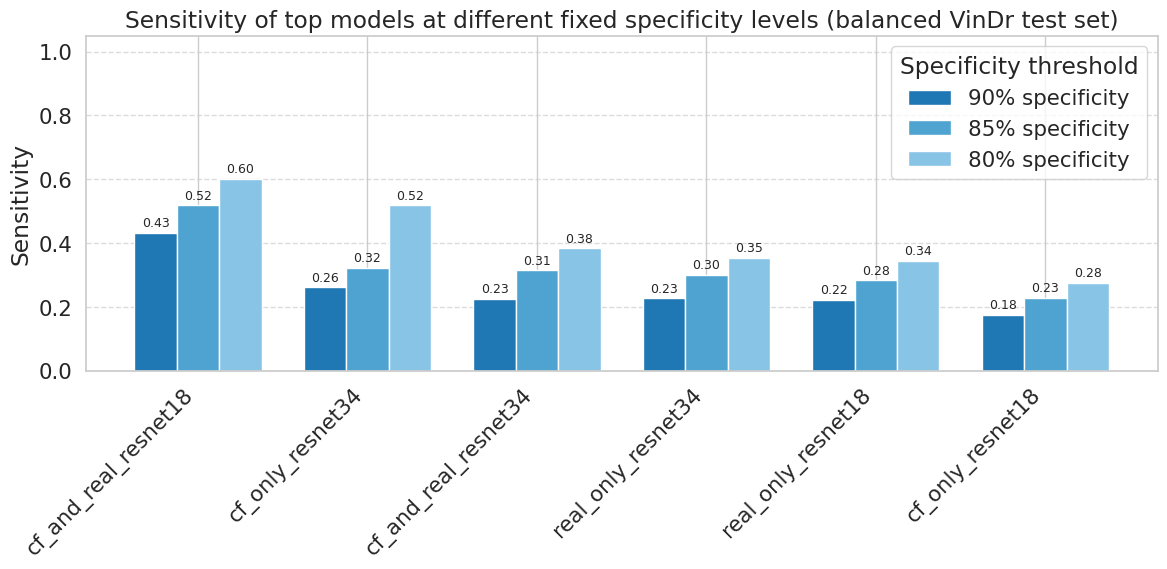

In [39]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load all CSVs
df90 = pd.read_csv('vindr-balanced-ts90-fixed-specificity.csv')
df85 = pd.read_csv('vindr-balanced-ts85-fixed-specificity.csv')
df80 = pd.read_csv('vindr-balanced-ts80-fixed-specificity.csv')

# Add column for target_spec
df90['target_spec'] = '90%'
df85['target_spec'] = '85%'
df80['target_spec'] = '80%'

# Concatenate
df_all = pd.concat([df90, df85, df80], ignore_index=True)

# Build model_label
df_all['model_label'] = df_all['name'] + '_' + df_all['model']

# Collapse duplicates → take mean sensitivity per (model_label, target_spec)
df_plot = df_all.groupby(['model_label', 'target_spec'])['sensitivity'].mean().reset_index()

# Select top N models overall (by max sensitivity across thresholds)
top_models = df_plot.groupby('model_label')['sensitivity'].max().sort_values(ascending=False).head(6).index.tolist()

# Filter to top models only
df_plot = df_plot[df_plot['model_label'].isin(top_models)]

# Sort models (same order across thresholds)
models = df_plot.groupby('model_label')['sensitivity'].max().sort_values(ascending=False).index.tolist()

# Bar plot settings
plt.figure(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(models))

# Colors for thresholds
colors = {
    '90%': '#1f77b4',  # dark blue
    '85%': '#4fa3d1',  # medium blue
    '80%': '#88c4e6',  # light blue
}

# Plot each threshold
for i, spec in enumerate(['90%', '85%', '80%']):
    df_spec = df_plot[df_plot['target_spec'] == spec]
    df_spec = df_spec.set_index('model_label').reindex(models)  # ensure order
    
    # Plot bars
    bars = plt.bar(x + i * bar_width, df_spec['sensitivity'], width=bar_width, color=colors[spec], label=f'{spec} specificity')
    
    # Add numbers on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Final plot formatting
plt.xticks(x + bar_width, models, rotation=45, ha='right')
plt.ylabel('Sensitivity')
plt.ylim(0, 1.05)
plt.title('Sensitivity of top models at different fixed specificity levels (balanced VinDr test set)')
plt.legend(title='Specificity threshold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

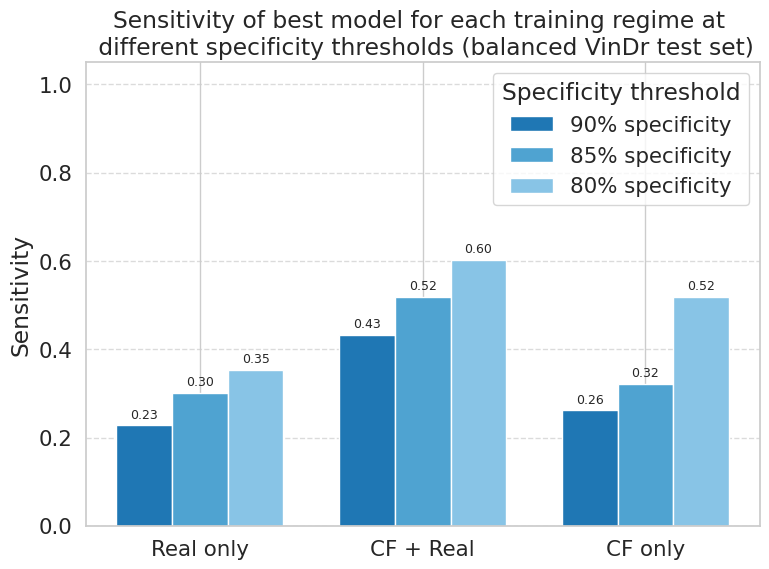

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load all CSVs
df90 = pd.read_csv('vindr-balanced-ts90-fixed-specificity.csv')
df85 = pd.read_csv('vindr-balanced-ts85-fixed-specificity.csv')
df80 = pd.read_csv('vindr-balanced-ts80-fixed-specificity.csv')

# Add column for target_spec
df90['target_spec'] = '90%'
df85['target_spec'] = '85%'
df80['target_spec'] = '80%'

# Concatenate
df_all = pd.concat([df90, df85, df80], ignore_index=True)

# Build model_label
df_all['model_label'] = df_all['name'] + '_' + df_all['model']

# Collapse duplicates → take mean sensitivity per (model_label, target_spec)
df_plot = df_all.groupby(['model_label', 'name', 'target_spec'])['sensitivity'].mean().reset_index()

# For each target_spec and each model name, select the best model_label
best_rows = []

for spec in ['90%', '85%', '80%']:
    for model_name in ['real_only', 'cf_and_real', 'cf_only']:
        df_sub = df_plot[(df_plot['target_spec'] == spec) & (df_plot['name'] == model_name)]
        
        if not df_sub.empty:
            # Select row with max sensitivity
            best_row = df_sub.loc[df_sub['sensitivity'].idxmax()]
            best_rows.append(best_row)

# Build new df_best
df_best = pd.DataFrame(best_rows)

# Now plot
plt.figure(figsize=(8, 6))
bar_width = 0.25
x = np.arange(3)  # 3 model types

# Colors for thresholds
colors = {
    '90%': '#1f77b4',  # dark blue
    '85%': '#4fa3d1',  # medium blue
    '80%': '#88c4e6',  # light blue
}

# Plot each threshold
for i, spec in enumerate(['90%', '85%', '80%']):
    df_spec = df_best[df_best['target_spec'] == spec]
    df_spec = df_spec.set_index('name').reindex(['real_only', 'cf_and_real', 'cf_only'])
    
    bars = plt.bar(x + i * bar_width, df_spec['sensitivity'], width=bar_width, color=colors[spec], label=f'{spec} specificity')
    
    # Add numbers on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Formatting
plt.xticks(x + bar_width, ['Real only', 'CF + Real', 'CF only'])
plt.ylabel('Sensitivity')
plt.ylim(0, 1.05)
plt.title('Sensitivity of best model for each training regime at \n different specificity thresholds (balanced VinDr test set)')
plt.legend(title='Specificity threshold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3545362/906743449.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(


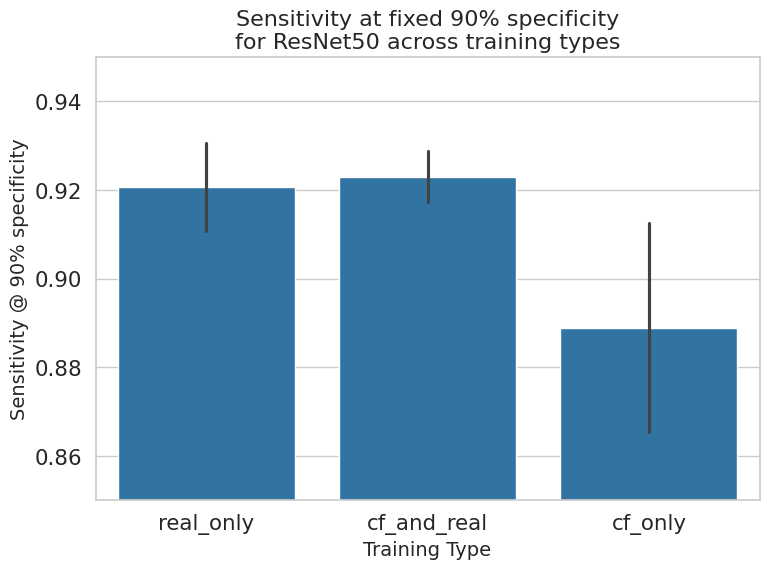

In [34]:
fixed_spec_results = '/vol/biomedic3/bglocker/ugproj/vg521/model/mammo-net/res-0.9-fixed-specificity.csv'

df = pd.read_csv(fixed_spec_results)

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.4)  # Increase font size for papers

# Create figure
plt.figure(figsize=(8, 6))

# Bar plot
ax = sns.barplot(
    data=df[df['model'] == 'resnet50'],
    x='name',
    y='sensitivity',
    ci='sd',  # Show SD for visual clarity
    color='#1f77b4'  # Consistent color
)

# Labels and title
plt.title('Sensitivity at fixed 90% specificity\nfor ResNet50 across training types', fontsize=16)
plt.ylabel('Sensitivity @ 90% specificity', fontsize=14)
plt.xlabel('Training Type', fontsize=14)

# Y-axis limits — optional, set based on your data
plt.ylim(0.85, 0.95)

# Tidy layout
plt.tight_layout()

# Show plot
plt.show()